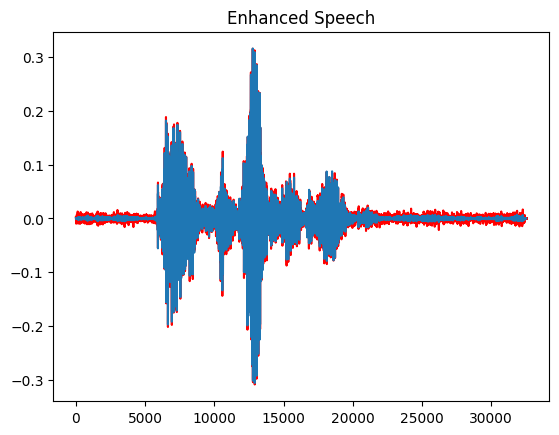

In [1]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math
import librosa

# input wave file 
f1 = "C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"
x, sr = librosa.load(f1, sr=16000)

# calculation parameters
n_fft = 512     # frame size in samples

hop = int(.5*n_fft)         # hop size in samples
hop = hop 

X = librosa.stft(x, n_fft=n_fft, hop_length=hop)

# setting default parameters
vad_db = 2       # VAD vad_dbhold in dB SNRseg
gamma = 1.0     # exp(gamma)
G = 1


nFFT = 512
# noise estimate from first 5 frames
noise_mean = np.zeros((nFFT//2+1))
for k in range(0, 5):
    noise_mean = noise_mean + abs(X[:, k])
    
noise_mu = noise_mean / 5

# initialize various variables
img = 1j
X_out = np.zeros(X.shape, dtype=complex)

# start
for n in range(0, X.shape[1]):
    # compute fourier transform of a frame
    signal_spec = X[:, n]
    # compute the magnitude
    signal_magnitude = abs(signal_spec)
    # save the noisy phase information
    theta = np.angle(signal_spec)
    # SNR
    SNRseg = 10 * np.log10(np.linalg.norm(signal_magnitude, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
    
    # --- spectral subtraction --- #
    clean_signal_magnitude = signal_magnitude ** gamma - noise_mu ** gamma
    
    # halfwave rectification (zero out negative values)
    clean_signal_magnitude = np.maximum(clean_signal_magnitude, 0)
 
    # --- implement a simple VAD detector --- #
    if SNRseg < vad_db:  # Update noise spectrum
        noise_temp = G * noise_mu ** gamma + (1 - G) * signal_magnitude ** gamma  # Smoothing processing noise power spectrum
        noise_mu = noise_temp ** (1 / gamma)  # New noise amplitude spectrum
        # clean_signal_magnitude = .3*signal_magnitude  # suppress the signal
    
    # add phase    
    phased_clean_signal = (clean_signal_magnitude ** (1 / gamma)) * np.exp(img * theta)       
    # store the output
    X_out[:, n] = phased_clean_signal

x_out = librosa.istft(X_out, hop_length=hop, n_fft=nFFT)

# plot wave
plt.plot(x, 'red')
plt.title('Noisy Speech')
plt.plot(x_out)
plt.title('Enhanced Speech')
plt.show()


In [2]:
import IPython.display as ipd
ipd.Audio(x_out, rate=sr)

In [3]:
ipd.Audio(x, rate=sr)